In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms 
import torchvision 
import torch.nn as nn
from sklearn.model_selection import train_test_split
import cv2
import os

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# download dataset

In [ ]:
class MaskDataset(Dataset):
  def __init__(self, root_dir, transform=None):
    self.list_images_path = []
    self.list_labels = []
    self.one_hot_label = {"nomask": 0, "mask": 1}
    for sub_dir in os.listdir(root_dir):
      path_sub_dir = os.path.join(root_dir, sub_dir)
      for image_name in os.listdir(path_sub_dir):
        image_path = os.path.join(path_sub_dir, image_name)
        label = sub_dir
        self.list_images_path.append(image_path)
        self.list_labels.append(label)
    
    self.transform = transform
  
  def __len__(self):
    return len(self.list_images_path)
  
  def __getitem__(self, idx):
    image = cv2.imread(self.list_images_path[idx])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (229, 229))
    image = image.astype('float')
    label = np.array(self.one_hot_label[self.list_labels[idx]]).astype('float')

    sample = (image, label)
    if self.transform:
      sample = self.transform(sample)
    
    return sample # image, label

In [ ]:
class convertToTensor:
  def __call__(self, sample):
    image, label = sample

    # opencv image: H x W x C
    # torch tensor: C x H x W
    image = torch.from_numpy(image).permute(2, 0, 1).float()
    label = torch.from_numpy(label).long()

    return (image, label)

In [ ]:
transformed_train_data = MaskDataset('dataset/train', transform=transforms.Compose([convertToTensor()]))
transformed_test_data = MaskDataset('dataset/val', transform=transforms.Compose([convertToTensor()]))

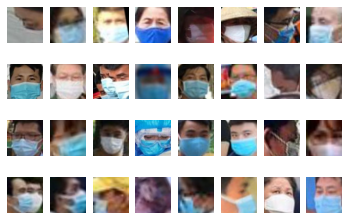

In [ ]:
col = 8
row = 4

fig = plt.figure()
for index in range(1, col*row + 1):
  plt.subplot(row, col, index)
  plt.axis('off')
  plt.imshow(cv2.resize(cv2.cvtColor(cv2.imread(transformed_train_data.list_images_path[index]), cv2.COLOR_BGR2RGB), (224, 224)))

In [ ]:
train_data_loader = DataLoader(transformed_train_data, batch_size=32, shuffle=True)
test_data_loader = DataLoader(transformed_test_data, batch_size=32, shuffle=True)

# InceptionResnet_v2

In [ ]:
class Conv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, stride=1, bias=True):
        super(Conv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=bias)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001, momentum=0.1)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class Reduction_A(nn.Module):
    # 35 -> 17
    def __init__(self, in_channels, k, l, m, n):
        super(Reduction_A, self).__init__()
        print("n: ", n)
        self.branch_0 = Conv2d(in_channels, n, 3, stride=2, padding=0, bias=False)
        self.branch_1 = nn.Sequential(
            Conv2d(in_channels, k, 1, stride=1, padding=0, bias=False),
            Conv2d(k, l, 3, stride=1, padding=1, bias=False),
            Conv2d(l, m, 3, stride=2, padding=0, bias=False),
        )
        self.branch_2 = nn.MaxPool2d(3, stride=2, padding=0)

    def forward(self, x):
        x0 = self.branch_0(x)
        x1 = self.branch_1(x)
        x2 = self.branch_2(x)
        return torch.cat((x0, x1, x2), dim=1) # 17 x 17 x 1024

In [ ]:
class Stem(nn.Module):
    def __init__(self, in_channels):
        super(Stem, self).__init__()
        self.features = nn.Sequential(
            Conv2d(in_channels, 32, 3, stride=2, padding=0, bias=False), # 149 x 149 x 32
            Conv2d(32, 32, 3, stride=1, padding=0, bias=False), # 147 x 147 x 32
            Conv2d(32, 64, 3, stride=1, padding=1, bias=False), # 147 x 147 x 64
            nn.MaxPool2d(3, stride=2, padding=0), # 73 x 73 x 64
            Conv2d(64, 80, 1, stride=1, padding=0, bias=False), # 73 x 73 x 80
            Conv2d(80, 192, 3, stride=1, padding=0, bias=False), # 71 x 71 x 192
            nn.MaxPool2d(3, stride=2, padding=0), # 35 x 35 x 192
        )
        self.branch_0 = Conv2d(192, 96, 1, stride=1, padding=0, bias=False)
        self.branch_1 = nn.Sequential(
            Conv2d(192, 48, 1, stride=1, padding=0, bias=False),
            Conv2d(48, 64, 5, stride=1, padding=2, bias=False),
        )
        self.branch_2 = nn.Sequential(
            Conv2d(192, 64, 1, stride=1, padding=0, bias=False),
            Conv2d(64, 96, 3, stride=1, padding=1, bias=False),
            Conv2d(96, 96, 3, stride=1, padding=1, bias=False),
        )
        self.branch_3 = nn.Sequential(
            nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False),
            Conv2d(192, 64, 1, stride=1, padding=0, bias=False)
        )
    def forward(self, x):
        x = self.features(x)
        x0 = self.branch_0(x)
        x1 = self.branch_1(x)
        x2 = self.branch_2(x)
        x3 = self.branch_3(x)
        return torch.cat((x0, x1, x2, x3), dim=1)


class Inception_ResNet_A(nn.Module):
    def __init__(self, in_channels, scale=1.0):
        super(Inception_ResNet_A, self).__init__()
        self.scale = scale
        self.branch_0 = Conv2d(in_channels, 32, 1, stride=1, padding=0, bias=False)
        self.branch_1 = nn.Sequential(
            Conv2d(in_channels, 32, 1, stride=1, padding=0, bias=False),
            Conv2d(32, 32, 3, stride=1, padding=1, bias=False)
        )
        self.branch_2 = nn.Sequential(
            Conv2d(in_channels, 32, 1, stride=1, padding=0, bias=False),
            Conv2d(32, 48, 3, stride=1, padding=1, bias=False),
            Conv2d(48, 64, 3, stride=1, padding=1, bias=False)
        )
        self.conv = nn.Conv2d(128, 320, 1, stride=1, padding=0, bias=True)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        x0 = self.branch_0(x)
        x1 = self.branch_1(x)
        x2 = self.branch_2(x)
        x_res = torch.cat((x0, x1, x2), dim=1)
        x_res = self.conv(x_res)
        return self.relu(x + self.scale * x_res)


class Inception_ResNet_B(nn.Module):
    def __init__(self, in_channels, scale=1.0):
        super(Inception_ResNet_B, self).__init__()
        self.scale = scale
        self.branch_0 = Conv2d(in_channels, 192, 1, stride=1, padding=0, bias=False)
        self.branch_1 = nn.Sequential(
            Conv2d(in_channels, 128, 1, stride=1, padding=0, bias=False),
            Conv2d(128, 160, (1, 7), stride=1, padding=(0, 3), bias=False),
            Conv2d(160, 192, (7, 1), stride=1, padding=(3, 0), bias=False)
        )
        self.conv = nn.Conv2d(384, 1088, 1, stride=1, padding=0, bias=True)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        x0 = self.branch_0(x)
        x1 = self.branch_1(x)
        x_res = torch.cat((x0, x1), dim=1)
        x_res = self.conv(x_res)
        return self.relu(x + self.scale * x_res)


class Reduciton_B(nn.Module):
    def __init__(self, in_channels):
        super(Reduciton_B, self).__init__()
        self.branch_0 = nn.Sequential(
            Conv2d(in_channels, 256, 1, stride=1, padding=0, bias=False),
            Conv2d(256, 384, 3, stride=2, padding=0, bias=False)
        )
        self.branch_1 = nn.Sequential(
            Conv2d(in_channels, 256, 1, stride=1, padding=0, bias=False),
            Conv2d(256, 288, 3, stride=2, padding=0, bias=False),
        )
        self.branch_2 = nn.Sequential(
            Conv2d(in_channels, 256, 1, stride=1, padding=0, bias=False),
            Conv2d(256, 288, 3, stride=1, padding=1, bias=False),
            Conv2d(288, 320, 3, stride=2, padding=0, bias=False)
        )
        self.branch_3 = nn.MaxPool2d(3, stride=2, padding=0)

    def forward(self, x):
        x0 = self.branch_0(x)
        x1 = self.branch_1(x)
        x2 = self.branch_2(x)
        x3 = self.branch_3(x)
        return torch.cat((x0, x1, x2, x3), dim=1)


class Inception_ResNet_C(nn.Module):
    def __init__(self, in_channels, scale=1.0, activation=True):
        super(Inception_ResNet_C, self).__init__()
        self.scale = scale
        self.activation = activation
        self.branch_0 = Conv2d(in_channels, 192, 1, stride=1, padding=0, bias=False)
        self.branch_1 = nn.Sequential(
            Conv2d(in_channels, 192, 1, stride=1, padding=0, bias=False),
            Conv2d(192, 224, (1, 3), stride=1, padding=(0, 1), bias=False),
            Conv2d(224, 256, (3, 1), stride=1, padding=(1, 0), bias=False)
        )
        self.conv = nn.Conv2d(448, 2080, 1, stride=1, padding=0, bias=True)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        x0 = self.branch_0(x)
        x1 = self.branch_1(x)
        x_res = torch.cat((x0, x1), dim=1)
        x_res = self.conv(x_res)
        if self.activation:
            return self.relu(x + self.scale * x_res)
        return x + self.scale * x_res


class Inception_ResNetv2(nn.Module):
    def __init__(self, classes=2, in_channels=3, k=256, l=256, m=384, n=384):
        super(Inception_ResNetv2, self).__init__()
        blocks = []
        blocks.append(Stem(in_channels))
        for i in range(10):
            blocks.append(Inception_ResNet_A(320, 0.17))
        blocks.append(Reduction_A(320, k, l, m, n))
        for i in range(20):
            blocks.append(Inception_ResNet_B(1088, 0.10))
        blocks.append(Reduciton_B(1088))
        for i in range(9):
            blocks.append(Inception_ResNet_C(2080, 0.20))
        blocks.append(Inception_ResNet_C(2080, activation=False))
        self.features = nn.Sequential(*blocks)
        self.conv = Conv2d(2080, 1536, 1, stride=1, padding=0, bias=False)
        self.global_average_pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(1536, classes)

    def forward(self, x):
        x = self.features(x)
        x = self.conv(x)
        x = self.global_average_pooling(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

In [ ]:
model = Inception_ResNetv2(2).to(device)

n:  384


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_function = nn.CrossEntropyLoss()

# Train

In [ ]:
'''
    Function for computing the accuracy of the predictions over the entire data_loader
'''
def get_accuracy(model, data_loader, device):
    correct = 0
    total = 0
    
    with torch.no_grad():
        model.eval()
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100*(correct/total)

'''
    Function for plotting training and validation losses
'''
def plot_losses(train_acc, valid_acc):
    # change the style of the plots to seaborn
    plt.style.use('seaborn')

    train_acc = np.array(train_acc)
    valid_acc = np.array(valid_acc)

    fig, ax = plt.subplots(figsize=(8, 4.5))

    ax.plot(train_acc, color="blue", label="Train_acc")
    ax.plot(valid_acc, color="red", label="Validation_acc")
    ax.set(title="Acc over epochs",
            xlabel="Epoch",
            ylabel="Acc")
    ax.legend()
    fig.show()

  # change the plot style to default
    plt.style.use('default')

'''
    function for the training step of the training loop
'''
def train(train_loader, model, criterion, optimizer, device):
    model.train()
    running_loss = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # backward and optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = running_loss / len(train_loader)

    return model, optimizer, epoch_loss 

'''
    function for the validation step of the training loop
'''
def validate(valid_loader, model, criterion, device):
    model.eval()
    running_loss = 0

    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)

        # forward pass and record loss
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(valid_loader)

    return model, epoch_loss

'''
    function defining the entire training loop
'''
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    # set object for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    list_train_acc = []
    list_val_acc = []

    valid_loss_min = np.Inf
    # train model
    for epoch in range(0, epochs):
        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)

        if epoch % print_every == print_every - 1:
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)


            print('Epochs: {}, Train_loss: {}, Valid_loss: {}, Train_accuracy: {}, Valid_accuracy: {}'.format(
                    epoch, train_loss, valid_loss, train_acc, valid_acc
                    ))

            list_train_acc.append(train_acc)
            list_val_acc.append(valid_acc)
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)

        if valid_loss < valid_loss_min:
            torch.save(model, 'model.pt')
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            valid_loss_min = valid_loss

    plot_losses(list_train_acc, list_val_acc)

    return model, optimizer, (train_losses, valid_losses)

In [ ]:
model, optimizer, _ = training_loop(model, loss_function, optimizer, train_data_loader, test_data_loader, 5, device)

Epochs: 0, Train_loss: 0.25454367730901184, Valid_loss: 0.2851190518547771, Train_accuracy: 92.08368674017528, Valid_accuracy: 89.72184531886025
Validation loss decreased (inf --> 0.285119).  Saving model ...


KeyboardInterrupt: ignored